### Download all the necessary packages

In [1]:
from ftplib import FTP
import os
import numpy as np
import matplotlib.pyplot as plt  # Plotting
from datetime import datetime, timedelta # Helps us correctly read and display the time
import cartopy.crs as ccrs # Maping 
import cartopy.feature as cfeature # Map features
import cartopy.io.shapereader as shpreader # Helps read shapfiles if we want to add additional features to the map
from metpy.plots import ctables, USCOUNTIES, add_timestamp # Color tables, US County lines, and function to add time to plots
from metpy.io import Level2File # Function that reads level 2 Data
from pyproj import Geod # Will help us change cartesian coordinates to latitude and longitude
import boto3 # Accessing radar data
import botocore
from botocore.client import Config

In [2]:
'''
The following function accesses level 2 nexrad data files. For more information
search docs.opendata.aws/noaa-nexrad/readme.html

The function takes two arguments, the date and the station. The date MUST
be a string in the form MM/DD/YYYY. Hour must be an integer. The station must be a four character
string, the station ID.
'''

def access_datafiles(date, hour, station):
    month, day, year = date.split('/')
    s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED, 
                                            user_agent_extra='Resource'))
    bucket = s3.Bucket('noaa-nexrad-level2')
    d = datetime(int(year), int(month), int(day), hour)
    prefix = f'{d:%Y}/{d:%m}/{d:%d}/{station}/{station}{d:%Y%m%d_%H}'
    objects = []
    for obj in bucket.objects.filter(Prefix = prefix):
        print(obj.key)
        objects.append(obj)
    return s3, objects

In [7]:
'''
Function that will be called to plot the radar. Accepts the output of Level2File() as an arguement.
'''

def plot_radar(f):
    sweep = 0

    az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

    ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
    ref_range = np.arange(ref_hdr.num_gates) * ref_hdr.gate_width + ref_hdr.first_gate

    ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])
    radarfilter = f.clutter_filter_bypass_map['data'][0]

    truedata = []
    for data_ray in ref:
        rows = []
        for data_point in data_ray:
            if data_point < 10:
                data_point = np.nan
                rows.append(data_point)
            else:
                rows.append(data_point)
        truedata.append(rows)

    truedata = np.array(truedata)
    #print(truedata)
    data = np.ma.array(truedata)
    data[np.isnan(data)] = np.ma.masked
    
    lat = f.sweeps[sweep][0][1].lat
    lon = f.sweeps[sweep][0][1].lon
    
    g = Geod(ellps='clrk66')
    
    center_lat = np.ones([len(az),len(ref_range)])*lat    
    center_lon = np.ones([len(az),len(ref_range)])*lon
    az2D = np.ones_like(center_lat)*az[:,None]
    rng2D = np.ones_like(center_lat)*np.transpose(ref_range[:,None])*1000
    lon,lat,back=g.fwd(center_lon,center_lat,az2D,rng2D)

    #xloc = ref_range * np.sin(np.deg2rad(az[:, np.newaxis]))
    #yloc = ref_range * np.cos(np.deg2rad(az[:, np.newaxis]))
    #print(data)
    norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity',-20,0.5)
    mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, shading = 'auto')
    
    data_time = f.dt
    time_stamp = add_timestamp(ax, time=data_time)
    time_stamp.set_fontsize(24)
    
    return mesh, time_stamp

In [4]:
'''
Function that plots city names.
'''

def plot_cities(extent, ax):
    pop = cfeature.NaturalEarthFeature(
            category = 'cultural',
            name = 'populated_places',
            scale = '10m',
            facecolor = 'none')
    pop = shpreader.natural_earth(resolution='10m', category='cultural', name='populated_places')
    shp = shpreader.Reader(pop)
    #xy = [pt.coords[0] for pt in shp.geometries()]
    #xcords,ycords = zip(*xy)

    lats = []
    lons = []
    USCities = []
    populations = []
    for record in shp.records():
        country = record.attributes['SOV0NAME']
        lat = record.attributes['LATITUDE']
        lon = record.attributes['LONGITUDE']
        population = record.attributes['POP_MAX']
        if extent[0]<lon<extent[1] and extent[2]<lat<extent[3]:
            USCities.append(record.attributes['NAME'])
            lats.append(lat)
            lons.append(lon)
            populations.append(population)
    if len(populations) > 30:
        Sorted = sorted(populations, reverse = True)[0:29]
        #print(Sorted)
        maximum = max(Sorted)
        minimum = min(Sorted)
    else:
        #print(populations)
        maximum = max(populations)
        minimum = min(populations)

    #print(maximum, minimum)
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    for i in range(len(USCities)):
        if minimum <= populations[i] <= maximum:
            ax.annotate(USCities[i], (lons[i],lats[i]), 
                        c = 'lightyellow', xycoords = transform, size = 24)

In [5]:
date = '3/28/2020'
hour = 23
station = 'KDVN'
s3, bucketlist = access_datafiles(date, hour, station)

2020/03/28/KDVN/KDVN20200328_230125_V06
2020/03/28/KDVN/KDVN20200328_230633_V06
2020/03/28/KDVN/KDVN20200328_231224_V06
2020/03/28/KDVN/KDVN20200328_232025_V06
2020/03/28/KDVN/KDVN20200328_232617_V06
2020/03/28/KDVN/KDVN20200328_233208_V06
2020/03/28/KDVN/KDVN20200328_233801_V06
2020/03/28/KDVN/KDVN20200328_234405_V06
2020/03/28/KDVN/KDVN20200328_235010_V06
2020/03/28/KDVN/KDVN20200328_235629_V06
2020/03/28/KDVN/KDVN20200328_235629_V06_MDM


Message 13 segments out of sync -- read -1 but on 2
Message 13 segments out of sync -- read -1 but on 3
Message 13 segments out of sync -- read -1 but on 4
Message 13 segments out of sync -- read -1 but on 5
Message 13 left data -- Used: 46080 Avail: 57605
C:\Users\Jonathan DeGraw\.conda\envs\MetPy\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


TypeError: matplotlib.font_manager.FontProperties() argument after ** must be a mapping, not int

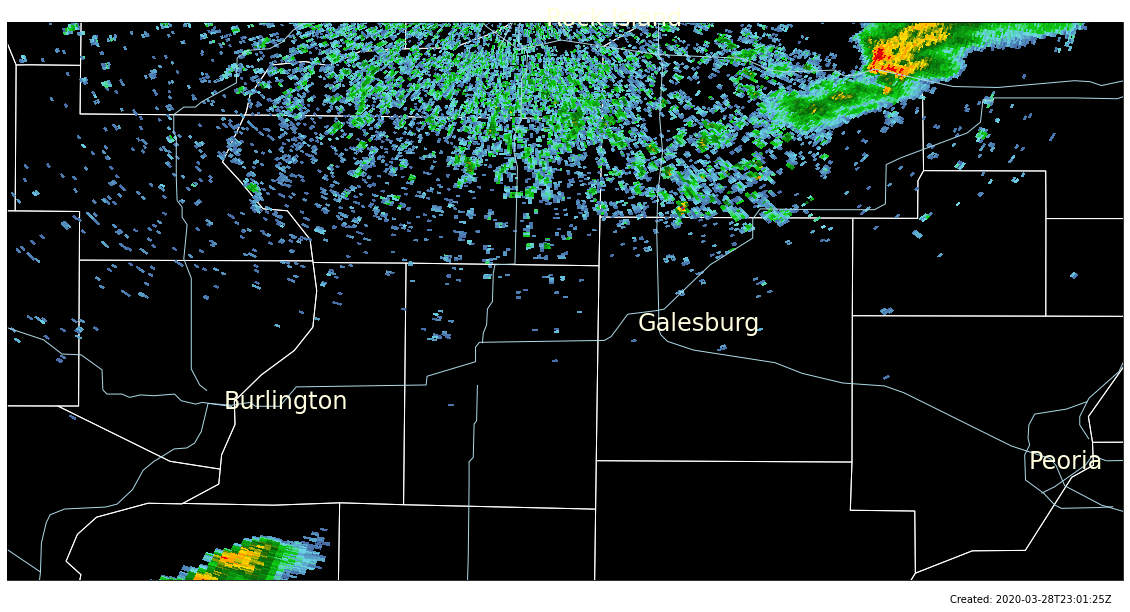

In [6]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(20,30))
ax = plt.subplot(projection = proj)
ax.set_facecolor('black')

artists = []
extent = [-91.5,-89.5,40.5,41.5]

ax.set_extent(extent)
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor = 'white', linewidth = 1, zorder = 0)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = 'white', zorder = 0)
roads = cfeature.NaturalEarthFeature(
        category='cultural',
        name='roads',
        scale='10m',
        facecolor='none')
ax.add_feature(roads, edgecolor='lightblue', linewidth = 1)
plot_cities(extent,ax)

artists = []
for file in bucketlist[0:len(bucketlist)-1]:
    f = Level2File(file.get()['Body'])
    mesh, time_stamp = plot_radar(f)
    artists.append([mesh,time_stamp])
    

plt.savefig('attempt2.png')


In [ ]:
plt.rcParams['animation.html'] = 'jshtml'

In [ ]:
from matplotlib.animation import ArtistAnimation

In [ ]:
anim = ArtistAnimation(fig,artists, interval = 400)
anim

In [ ]:
anim.save('Radar2020-03-28_T2356_Level2_Small.gif', writer = 'imagemagick')